# 实验二：动态规划

**姓名：** 

龙硕

**学号：** 

21281165

## 实验目的

* 对所交互环境有一定程度了解，如理解环境中的状态、动作、奖励、转移概率表示形式；
* 根据算法的伪代码，熟悉相关算法的实际编码形式，深入理解算法思想，掌握动态规划算法解决具体问题中的核心环节。

## 1. 动态规划算法

### 策略迭代 (Policy Iteration)

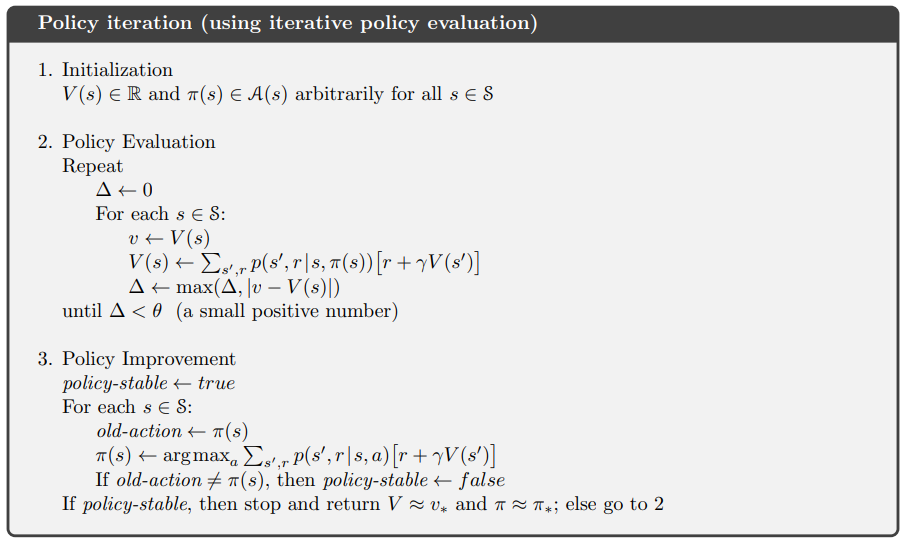

### 值迭代 (Value Iteration)

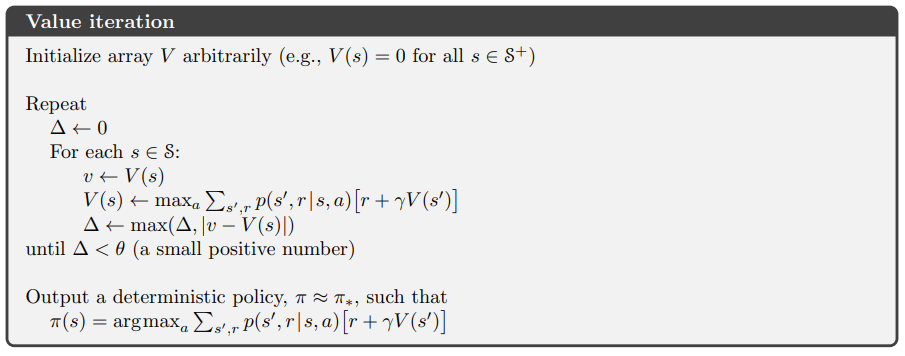

## 2. 实验环境

In [1]:
import gym
import numpy as np
import copy

冰湖是 OpenAI Gym 库中的一个环境。OpenAI Gym 库中包含了很多有名的环境，例如 Atari 和 MuJoCo，并且支持我们定制自己的环境。在之后的实验中，我们还会使用到更多来自 OpenAI Gym 库的环境。如下图所示，冰湖环境是一个网格世界，大小为**4x4**。每一个方格是一个状态，智能体起点状态在左上角**S**，目标状态在右下角**G**，中间还有若干冰洞**H**。在每一个状态都可以采取上**、下、左、右 4 个动作。由于智能体在冰面行走，因此每次行走都有一定的概率滑行到附近的其它状态，并且到达冰洞或目标状态时行走会提前结束。每一步行走的奖励是 0，到达目标的奖励是 1。

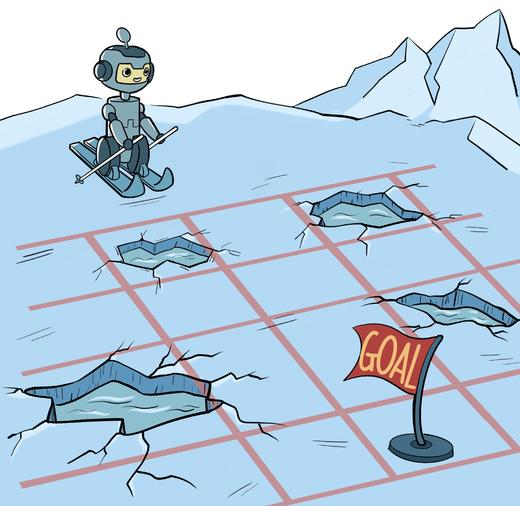

In [2]:
# env = gym.make("FrozenLake-v0")  # 创建环境
# linux
env = gym.make("FrozenLake-v1")  # 创建环境
env = env.unwrapped  # 解封装才能访问状态转移矩阵P
env.render()  # 环境渲染,通常是弹窗显示或打印出可视化的环境


SFFF
FHFH
FFFH
HFFG


S：起始点  <br>
F：安全地带 <br>
H：陷阱 <br>
G：目的地 <br>

### 随机生成一些动作

In [3]:
for i in range(10):
    print(env.action_space.sample())

1
3
1
2
0
3
3
3
0
3


0：代表向左移动 <br>
1：代表向下移动 <br>
2：代表向右移动 <br>
3：代表向上移动 <br>

### 查看当前环境的转移概率矩阵示例：

In [4]:
env.P[0][0]

[(0.3333333333333333, 0, 0.0, False),
 (0.3333333333333333, 0, 0.0, False),
 (0.3333333333333333, 4, 0.0, False)]

In [5]:
env.P[0]

{0: [(0.3333333333333333, 0, 0.0, False),
  (0.3333333333333333, 0, 0.0, False),
  (0.3333333333333333, 4, 0.0, False)],
 1: [(0.3333333333333333, 0, 0.0, False),
  (0.3333333333333333, 4, 0.0, False),
  (0.3333333333333333, 1, 0.0, False)],
 2: [(0.3333333333333333, 4, 0.0, False),
  (0.3333333333333333, 1, 0.0, False),
  (0.3333333333333333, 0, 0.0, False)],
 3: [(0.3333333333333333, 1, 0.0, False),
  (0.3333333333333333, 0, 0.0, False),
  (0.3333333333333333, 0, 0.0, False)]}

P[state][action]存储的是，在状态s下采取动作a获得的一系列数据，即<br>

**转移概率**：0.3333<br>
**下一步状态**：数字0-15 <br>
**奖励**： 0 或 1<br>
**完成标志**： False 或 True<br>


In [6]:
# 4*4的网格，有16个格子（状态），分别用0-15表示。eon=16
eon = env.observation_space.n
# 4个动作——上下左右，分别用0-3表示。ean=4
ean = env.action_space.n


holes = set()
ends = set()
for s in env.P:
    for a in env.P[s]:
        for s_ in env.P[s][a]:
            if s_[2] == 1.0:  # 获得奖励为1,代表是目标
                ends.add(s_[1])
            if s_[3] == True:
                holes.add(s_[1])
holes = holes - ends
print("冰洞的索引:", holes)
print("目标的索引:", ends)

for a in env.P[14]:  # 查看目标左边一格的状态转移信息
    print(env.P[14][a])

冰洞的索引: {11, 12, 5, 7}
目标的索引: {15}
[(0.3333333333333333, 10, 0.0, False), (0.3333333333333333, 13, 0.0, False), (0.3333333333333333, 14, 0.0, False)]
[(0.3333333333333333, 13, 0.0, False), (0.3333333333333333, 14, 0.0, False), (0.3333333333333333, 15, 1.0, True)]
[(0.3333333333333333, 14, 0.0, False), (0.3333333333333333, 15, 1.0, True), (0.3333333333333333, 10, 0.0, False)]
[(0.3333333333333333, 15, 1.0, True), (0.3333333333333333, 10, 0.0, False), (0.3333333333333333, 13, 0.0, False)]


不难发现冰洞的索引是{11, 12, 5, 7}（集合 set 的索引是无序的），起点状态（索引为 0）在左上角。其次，根据第 15 个状态（即目标左边一格，数组下标索引为 14）的信息，我们可以看到每个动作都会等概率“滑行”到 3 种可能的结果
<br>
<br>
<br>

## 3. 实验内容

### 策略迭代算法

In [7]:
class PolicyIteration:
    """ 策略迭代算法 """
    def __init__(self, env, theta, gamma):
        self.env = env
        self.v = [0] * self.env.ncol * self.env.nrow  # 初始化价值为0
        self.pi = [[0.25, 0.25, 0.25, 0.25]
                   for i in range(self.env.ncol * self.env.nrow)]  # 初始化为均匀随机策略
        self.theta = theta  # 策略评估收敛阈值
        self.gamma = gamma  # 折扣因子

    def policy_evaluation(self):  # 策略评估
        cnt = 1  # 计数器
        while 1:
            max_diff = 0
            new_v = [0] * self.env.ncol * self.env.nrow
            for s in range(self.env.ncol * self.env.nrow):
                qsa_list = []  # 开始计算状态s下的所有Q(s,a)价值
                for a in range(4):
                    qsa = 0
                    for res in self.env.P[s][a]:
                        p, next_state, r, done = res
                        qsa += p * (r + self.gamma * self.v[next_state])  # 根据贝尔曼方程计算状态动作值
                        
                        # 本次实验环境比较特殊,奖励和下一个状态有关,所以需要和状态转移概率相乘
                    qsa_list.append(self.pi[s][a] * qsa)
                new_v[s] = sum(qsa_list)  # 状态价值函数和动作价值函数之间的关系
                max_diff = max(max_diff, abs(new_v[s] - self.v[s]))
            self.v = new_v
            if max_diff < self.theta: break  # 满足收敛条件,退出评估迭代
            cnt += 1
        print("策略评估进行%d轮后完成" % cnt)

    def policy_improvement(self):  # 策略提升
        new_pi = []
        for s in range(self.env.nrow * self.env.ncol):
            qsa_list = []
            for a in range(4):
                qsa = 0
                for res in self.env.P[s][a]:
                    p, next_state, r, done = res
                    qsa += p * (r + self.gamma * self.v[next_state])
                    
                qsa_list.append(qsa)
            maxq = max(qsa_list)
            # cntq = qsa_list.count(maxq)  # 计算有几个动作得到了最大的Q值
            # 让这些动作均分概率
            best_actions = [i for i, q in enumerate(qsa_list) if q == maxq]  # 找到得到最大值的动作
            prob_per_action = 1.0 / len(best_actions)
            new_pi.append([prob_per_action if i in best_actions else 0 for i in range(4)])  # 更新策略
        print("策略提升完成")
        return new_pi

    def policy_iteration(self):  # 策略迭代
        while 1:
            self.policy_evaluation()
            old_pi = copy.deepcopy(self.pi)  # 将列表进行深拷贝,方便接下来进行比较
            new_pi = self.policy_improvement()
            if old_pi == new_pi: break
            self.pi = new_pi

### 价值迭代算法

In [8]:
class ValueIteration:
    """ 价值迭代算法 """
    def __init__(self, env, theta, gamma):
        self.env = env
        self.v = [0] * self.env.ncol * self.env.nrow  # 初始化价值为0
        self.theta = theta  # 价值收敛阈值
        self.gamma = gamma
        # 价值迭代结束后得到的策略
        self.pi = [None for i in range(self.env.ncol * self.env.nrow)]

    def value_iteration(self):
        cnt = 0
        while 1:
            max_diff = 0
            new_v = [0] * self.env.ncol * self.env.nrow
            for s in range(self.env.ncol * self.env.nrow):
                qsa_list = []  # 开始计算状态s下的所有Q(s,a)价值
                for a in range(4):
                    qsa = 0
                    for res in self.env.P[s][a]:
                        p, next_state, r, done = res
                        qsa += p * (r + self.gamma * self.v[next_state] * (1 - done))  # 根据贝尔曼方程计算状态动作值
                        
                    qsa_list.append(qsa)  # 这一行和下一行代码是价值迭代和策略迭代的主要区别
                    
                new_v[s] = max(qsa_list) # 更新状态价值函数
                max_diff = max(max_diff, abs(new_v[s] - self.v[s]))
            self.v = new_v
            if max_diff < self.theta: break  # 满足收敛条件,退出评估迭代
            cnt += 1
        print("价值迭代一共进行%d轮" % cnt)
        self.get_policy()

    def get_policy(self):  # 根据价值函数导出一个贪婪策略
        for s in range(self.env.nrow * self.env.ncol):
            qsa_list = []
            for a in range(4):
                qsa = 0
                for res in self.env.P[s][a]:
                    p, next_state, r, done = res
                    qsa += p * (r + self.gamma * self.v[next_state] * (1 - done))
                qsa_list.append(qsa)
                
            max_q = max(qsa_list)
            best_actions = [i for i, q in enumerate(qsa_list) if q == max_q]  # 找到得到最大值的动作
            cntq = len(best_actions)  # 计算有几个动作得到了最大的Q值
            
            cntq = qsa_list.count(max_q)  # 计算有几个动作得到了最大的Q值
            # 让这些动作均分概率
            self.pi[s] = [1 / cntq if q == max_q else 0 for q in qsa_list]

In [9]:
def print_agent(agent, action_meaning, disaster=[], end=[]):
    print("状态价值：")
    for i in range(agent.env.nrow):
        for j in range(agent.env.ncol):
            # 为了输出美观,保持输出6个字符
            print('%6.6s' % ('%.3f' % agent.v[i * agent.env.ncol + j]), end=' ')
        print()

    print("策略：")
    for i in range(agent.env.nrow):
        for j in range(agent.env.ncol):
            # 一些特殊的状态,例如悬崖漫步中的悬崖
            if (i * agent.env.ncol + j) in disaster:
                print('****', end=' ')
            elif (i * agent.env.ncol + j) in end:  # 目标状态
                print('EEEE', end=' ')
            else:
                a = agent.pi[i * agent.env.ncol + j]
                pi_str = ''
                for k in range(len(action_meaning)):
                    pi_str += action_meaning[k] if a[k] > 0 else 'o'
                print(pi_str, end=' ')
        print()


In [10]:
# 这个动作意义是Gym库针对冰湖环境事先规定好的
action_meaning = ['<', 'v', '>', '^']
theta = 1e-5
gamma = 0.9
agent = PolicyIteration(env, theta, gamma)
agent.policy_iteration()
print_agent(agent, action_meaning, [5, 7, 11, 12], [15])

策略评估进行25轮后完成
策略提升完成
策略评估进行58轮后完成
策略提升完成
状态价值：
 0.069  0.061  0.074  0.056 
 0.092  0.000  0.112  0.000 
 0.145  0.247  0.300  0.000 
 0.000  0.380  0.639  0.000 
策略：
<ooo ooo^ <ooo ooo^ 
<ooo **** <o>o **** 
ooo^ ovoo <ooo **** 
**** oo>o ovoo EEEE 


这个最优策略很看上去比较反直觉，其原因是这是一个智能体会随机滑向其他状态的冰冻湖面。例如，在目标左边一格的状态，采取向右的动作时，它有可能会滑到目标左上角的位置，从该位置再次到达目标会更加困难，所以此时采取向下的动作是更为保险的，并且有一定概率能够滑到目标。我们再来尝试一下价值迭代算法。

In [11]:
action_meaning = ['<', 'v', '>', '^']
theta = 1e-5
gamma = 0.9
agent = ValueIteration(env, theta, gamma)
agent.value_iteration()
print_agent(agent, action_meaning, [5, 7, 11, 12], [15])

价值迭代一共进行60轮
状态价值：
 0.069  0.061  0.074  0.056 
 0.092  0.000  0.112  0.000 
 0.145  0.247  0.300  0.000 
 0.000  0.380  0.639  0.000 
策略：
<ooo ooo^ <ooo ooo^ 
<ooo **** <o>o **** 
ooo^ ovoo <ooo **** 
**** oo>o ovoo EEEE 


可以发现价值迭代算法的结果和策略迭代算法的结果完全一致，这也互相验证了各自的结果。

## 4. 问题

1. 什么是策略迭代？什么是价值迭代？阐述其与动态规划的联系。

1. 通过策略评估，估计当前策略下的值函数；然后，通过策略改进，根据估计的值函数更新策略。这两个步骤交替进行，直到策略不再改变，即收敛到最优策略为止
2. 价值迭代是一种直接通过迭代更新值函数来寻找最优策略的方法。在每一次迭代中，根据贝尔曼最优方程，直接更新状态值函数（或状态-动作值函数），不需要明确地对策略进行评估和改进。迭代直到值函数收敛为止
3. 策略迭代和价值迭代都是动态规划的方法

2. 策略迭代和价值迭代的区别？

1. 策略迭代通过维护一个策略和值函数的交替迭代过程，更加注重策略的改进。而价值迭代直接通过迭代更新值函数来寻找最优策略，更加注重值函数的更新和优化

3. 你认为哪种策略学习方式更好？为什么？

1. 策略迭代的理论保证是可以收敛到最优策略的，即使在非马尔可夫决策过程（Non-Markov Decision Processes）中也能有效。策略迭代过程中，每一步都对应着一个改进的策略，因此可以清晰地理解算法的每一步是如何改进策略的。策略迭代直接从策略空间中搜索最优策略，因此在某些问题中更容易找到最优解。
2. 价值迭代通常比策略迭代计算量更小，因为它直接在值函数空间中进行迭代更新，不需要明确地维护策略。在某些情况下，价值迭代的收敛速度可能比策略迭代更快，尤其是在状态空间较大的情况下。

4. 本次实验心得体会